In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV3'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

THETA = math.pi/2

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_and_concatenate_with_signals(X_train, Y_train, theta=THETA, increment_percentage=2)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v3(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
436/436 [==============================] - 46s 72ms/step - loss: 1.6876 - val_loss: 6.0694
Epoch 2/100
436/436 [==============================] - 31s 71ms/step - loss: 1.2299 - val_loss: 1.2035
Epoch 3/100
436/436 [==============================] - 31s 70ms/step - loss: 1.1879 - val_loss: 1.1346 - loss
Epoch 4/100
436/436 [==============================] - 34s 78ms/step - loss: 1.1584 - val_loss: 1.0882
Epoch 5/100
436/436 [==============================] - 33s 77ms/step - loss: 1.1261 - val_loss: 1.0789
Epoch 6/100
436/436 [==============================] - 33s 76ms/step - loss: 1.1042 - val_loss: 1.0395
Epoch 7/100
436/436 [==============================] - 33s 77ms/step - loss: 1.0889 - val_loss: 1.0255
Epoch 8/100
436/436 [==============================] - 33s 76ms/step - loss: 1.0724 - val_loss: 1.0270
Epoch 9/100
436/436 [==============================] - 31s 72ms/step - loss: 1.0555 - val_loss: 1.0203- ETA: 2s - lo
Epoch 10/100
436/436 [==============================

# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 2s 28ms/step - loss: 1.2547
1.2546769380569458


## Loss

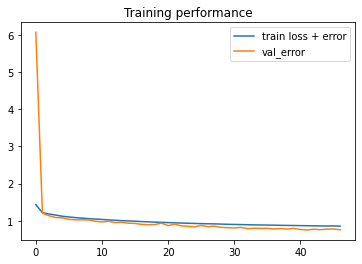

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

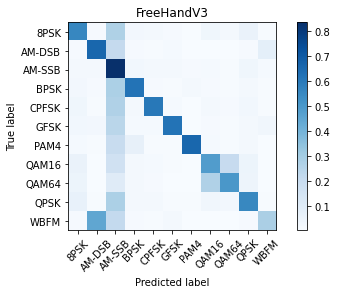

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08692421991084695
Overall Accuracy:  0.09426987060998152
Overall Accuracy:  0.1007423117709438
Overall Accuracy:  0.11770906535488405
Overall Accuracy:  0.1329479768786127
Overall Accuracy:  0.188327962764053
Overall Accuracy:  0.31637405947689
Overall Accuracy:  0.4800145348837209
Overall Accuracy:  0.625133120340788
Overall Accuracy:  0.7652767792954709
Overall Accuracy:  0.8373275236020334
Overall Accuracy:  0.855751893256401
Overall Accuracy:  0.8736242884250475
Overall Accuracy:  0.8701492537313433
Overall Accuracy:  0.8789625360230547
Overall Accuracy:  0.8778709442216551
Overall Accuracy:  0.8756016290262866
Overall Accuracy:  0.8725084618277548
Overall Accuracy:  0.8750921149594694
Overall Accuracy:  0.8698924731182796


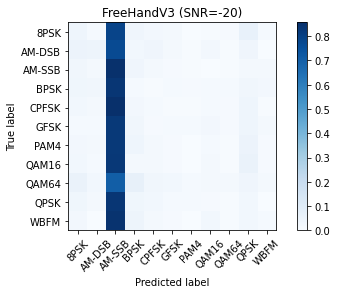

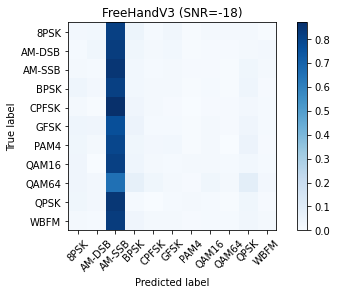

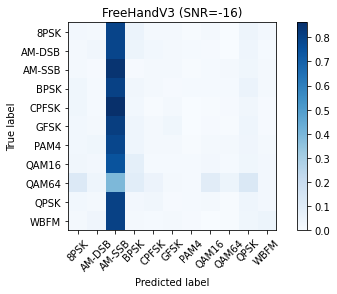

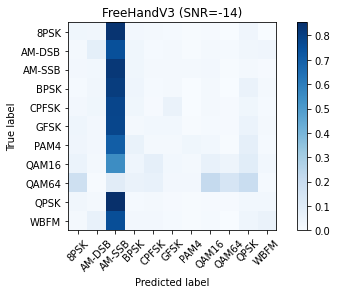

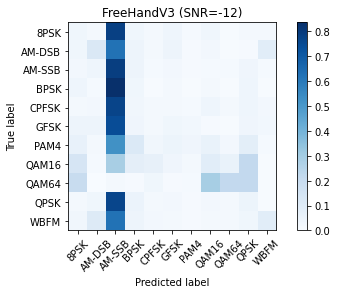

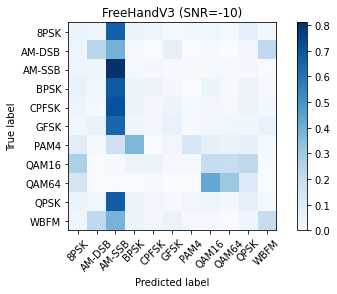

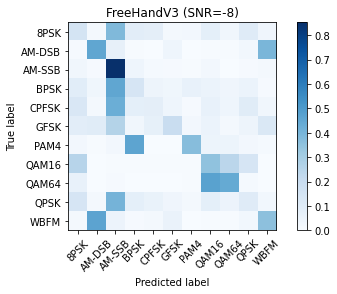

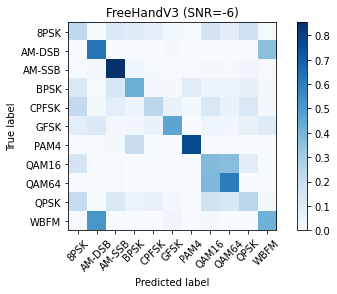

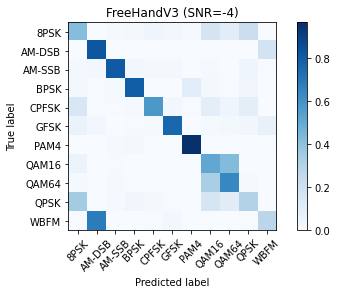

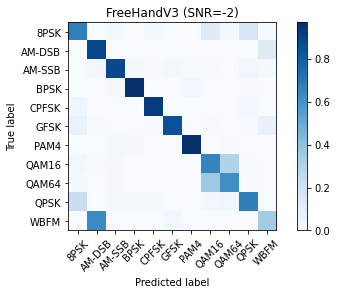

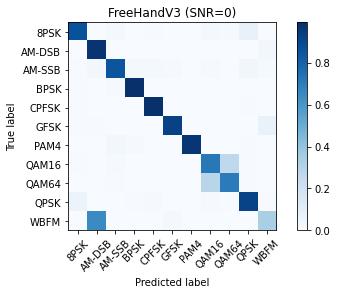

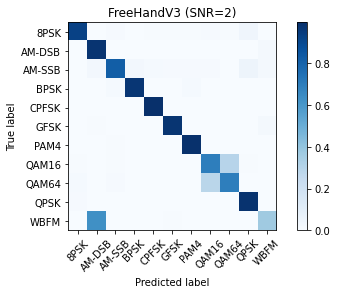

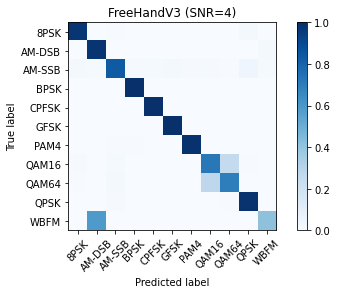

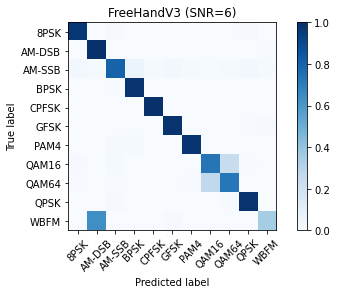

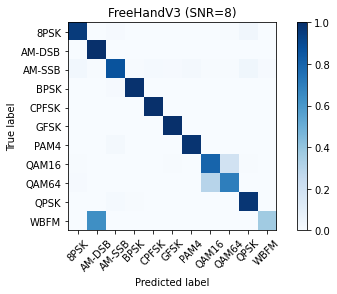

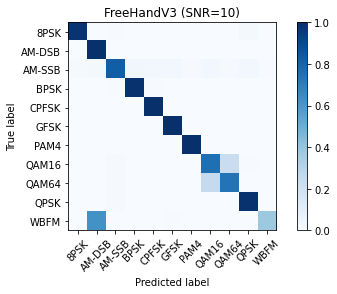

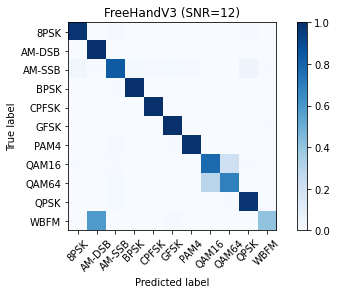

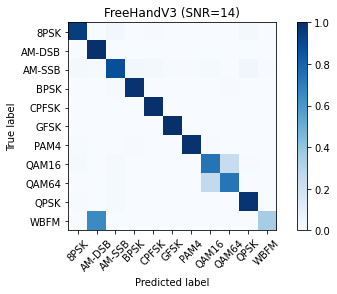

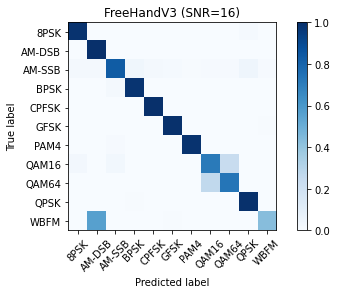

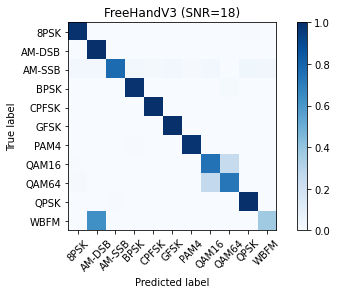

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,10,11,13,18,31,48,62,76,83,85,87,87,87,87,87,87,87,86


In [18]:
import statistics

statistics.mean(acc.values())

0.5797250509738758

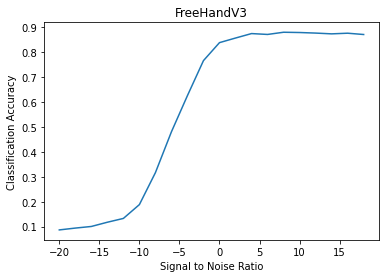

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)